<a href="https://www.kaggle.com/code/jorgeluiscruzquispe/pp-evap-basin?scriptVersionId=193511733" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## <center>Precipitation, Evapotranspiration, and Water Balance of basin<center>
---

In [2]:
!pip install -q geemap

In [3]:
import geemap.foliumap as geemap
import geemap.colormaps as cmap
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import ee

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AQlEd8wMDXDXU6emMXIlk8PwLuvZBLwe-B6huYB-JZW1FgPOVbHXEiPtGPw



Successfully saved authorization token.


## Monthly basin areal precipitation

In [6]:
cuenca = "Cuenca Mala"

startYear = 1982

endYear = 2023

In [ ]:
Map = geemap.Map()

startDate = ee.Date.fromYMD(startYear, 1, 1)

endDate = ee.Date.fromYMD(endYear + 1, 1, 1)

years = ee.List.sequence(startYear, endYear)

months = ee.List.sequence(1, 12)

chirp = ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                                                 .select(['precipitation'])\
                                                 .filterDate(startDate, endDate))
                         
# chirp_v6 = chirp.sum()

# load vector cuenca
basin = ee.FeatureCollection('users/mportuguez/CuencasPeru')

# Seleccionar cuenca
selected = basin.filter(ee.Filter.eq('NOMBRE', cuenca))
roi = selected.geometry()

# chirp_corte = chirp_v6.clip(roi)

chirp_date = chirp.filterDate(startDate, endDate)

def f1(y):
    def f2(m):
        w = chirp_date.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum()
        return w.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f2)

testing = years.map(f1)
list_img_flat = ee.List(testing.flatten())
list_img_col = ee.ImageCollection.fromImages(list_img_flat)
list_img = list_img_col.toList(list_img_col.size())

range_values = []; range_date = []

for i in range(0, list_img_col.size().getInfo()):
    list_image_i = list_img.get(i)
    image_i = ee.Image(list_image_i)
    mean_image = image_i.reduceRegion(reducer = ee.Reducer.mean(), geometry = roi, scale = 5000)
    pp_value = mean_image.getInfo()["precipitation"]
    range_values.append(pp_value)
    
    value_time_image = list_image_i.getInfo()["properties"]["system:time_start"]["value"]
    time_second = datetime.utcfromtimestamp(value_time_image/1000)
    year_val = time_second.year; month_val = time_second.month; day_val = time_second.day
    time_string = f"{year_val}-{month_val}-{day_val}"
    range_date.append(time_string)

df_pp = pd.DataFrame({"datos": range_values,"time": range_date})

df_pp = pd.DataFrame({"values": range_values,"time": range_date})
df_pp['time'] = pd.to_datetime(df_pp['time'], format='%Y-%m-%d')
df_pp = df_pp.set_index("time")

plt.figure(figsize = (15, 2.5))
plt.bar(df_pp.index, df_pp["values"], color = "red", alpha = 0.5, width = 20, label = "data")
plt.title("Monthly Precipitation", loc = "left")
plt.ylabel("Precipitation (mm)", style = "italic")
plt.xlabel("Time", style = "italic")
plt.grid(True, c = "silver", lw = 0.75)
plt.legend()
plt.show()

#centrar y zoom
Map.centerObject(chirp_corte)

# visualizar imagen
Map.addLayer(ee.Image().paint(basin, 0, 2), {'palette': 'black'}, "Cuencas del Perú")
# Map.addLayer(ee.ImageCollection(chirp_corte), {"palette": cmap.palettes.jet, "max": 1700, "min": 0}, 'Precipitation', opacity = 0.5)
Map.addLayer(ee.Image().paint(selected, 0, 2.5), {'palette': 'red'}, cuenca)

Map

## Monthly basin areal evapotranspiration

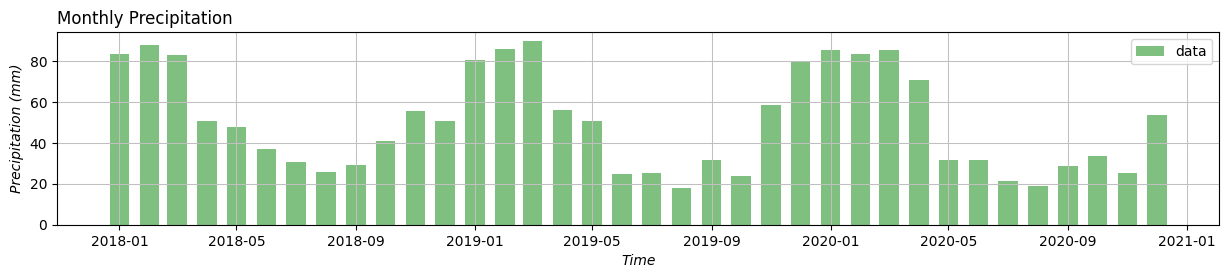

In [10]:
#Centrar imagen
Map = geemap.Map()

# Set start and end years.
startYear = 2018
endYear = 2020

# Create two date objects for start and end years.
startDate = ee.Date.fromYMD(startYear, 1, 1)
endDate = ee.Date.fromYMD(endYear + 1, 1, 1)

# Make a list with years.
years = ee.List.sequence(startYear, endYear)

# Make a list with months.
months = ee.List.sequence(1, 12)

#Load pp Chirps
modis = ee.ImageCollection(ee.ImageCollection("MODIS/006/MOD16A2")\
                                                 .select(['ET'])\
                                                 .filterDate(startDate, endDate))
                         
modis_sume = modis.sum()

# load vector cuenca
basin = ee.FeatureCollection('users/mportuguez/CuencasPeru')

# Seleccionar cuenca
selected = basin.filter(ee.Filter.eq('NOMBRE', cuenca))
roi = selected.geometry()

modis_corte = modis_sume.clip(roi)

modis_date = modis.filterDate(startDate, endDate)

def f1(y):
    def f2(m):
        w = modis_date.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum().multiply(0.1)
        return w.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f2)

testing = years.map(f1)
list_img_flat = ee.List(testing.flatten())
list_img_col = ee.ImageCollection.fromImages(list_img_flat)
list_img = list_img_col.toList(list_img_col.size())

range_values = []; range_date = []

for i in range(0, list_img_col.size().getInfo()):
    list_image_i = list_img.get(i)
    image_i = ee.Image(list_image_i)
    mean_image = image_i.reduceRegion(reducer = ee.Reducer.mean(), geometry = roi, scale = 5000)
    pp_value = mean_image.getInfo()["ET"]
    range_values.append(pp_value)
    
    value_time_image = list_image_i.getInfo()["properties"]["system:time_start"]["value"]
    time_second = datetime.utcfromtimestamp(value_time_image/1000)
    year_val = time_second.year; month_val = time_second.month; day_val = time_second.day
    time_string = f"{year_val}-{month_val}-{day_val}"
    range_date.append(time_string)

df_evap = pd.DataFrame({"datos": range_values,"time": range_date})

df_evap = pd.DataFrame({"values": range_values,"time": range_date})
df_evap['time'] = pd.to_datetime(df_evap['time'], format='%Y-%m-%d')
df_evap = df_evap.set_index("time")

plt.figure(figsize = (15, 2.5))
plt.bar(df_evap.index, df_evap["values"], color = "green", alpha = 0.5, width = 20, label = "data")
plt.title("Monthly Precipitation", loc = "left")
plt.ylabel("Precipitation (mm)", style = "italic")
plt.xlabel("Time", style = "italic")
plt.grid(True, c = "silver", lw = 0.75)
plt.legend()
plt.show()

#centrar y zoom
Map.centerObject(chirp_corte)

# visualizar imagen
Map.addLayer(ee.Image().paint(basin, 0, 2), {'palette': 'black'}, "Cuencas del Perú")
Map.addLayer(ee.ImageCollection(modis_corte), {"palette": cmap.palettes.jet, "max": 1000, "min": 0}, 'Precipitation', opacity = 0.5)
Map.addLayer(ee.Image().paint(selected, 0, 2.5), {'palette': 'red'}, cuenca)

Map

## Monthly areal water balance of the basin

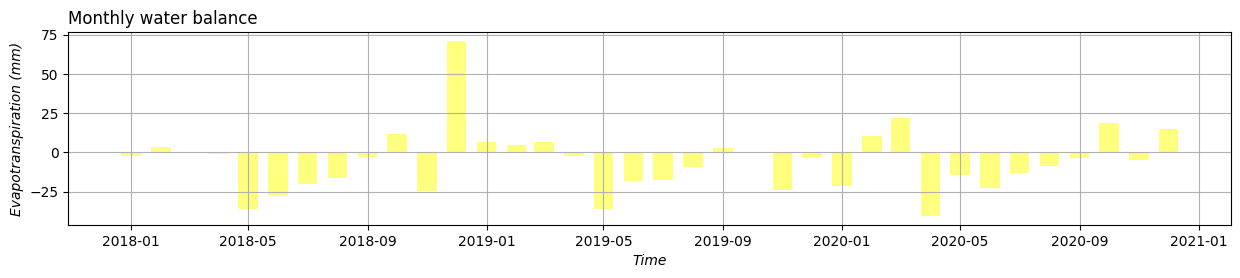

In [11]:
#Centrar imagen
Map = geemap.Map()

# Set start and end years.
startYear = 2018
endYear = 2020

# Create two date objects for start and end years.
startDate = ee.Date.fromYMD(startYear, 1, 1)
endDate = ee.Date.fromYMD(endYear + 1, 1, 1)

years = ee.List.sequence(startYear, endYear)

# Make a list with months.
months = ee.List.sequence(1, 12)

#Load pp Chirps
chirp = ee.ImageCollection(ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")\
                                                 .select(['precipitation'])\
                                                 .filterDate(startDate, endDate))

modis = ee.ImageCollection(ee.ImageCollection("MODIS/006/MOD16A2")\
                                                 .select(['ET'])\
                                                 .filterDate(startDate, endDate))
                         
chirp_v6 = chirp.sum()

# load vector cuenca
basin = ee.FeatureCollection('users/mportuguez/CuencasPeru')

# Seleccionar cuenca
selected = basin.filter(ee.Filter.eq('NOMBRE', cuenca))
roi = selected.geometry()

chirp_corte = chirp_v6.clip(roi)

chirp_date = chirp.filterDate(startDate, endDate)

def f40(y):
    def f41(m):
        P = chirp.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum()
        ET = modis.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m,'month')).sum().multiply(0.1)
        wb = P.subtract(ET).rename('wb')
        return wb.set('year', y).set('month', m).set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(f41)

listimage = years.map(f40)

listimages = ee.List(listimage.flatten())

waterBalance = ee.ImageCollection.fromImages(listimages)

lista_de_imagenes = waterBalance.toList(waterBalance.size())


bal_me = []
range_time = []

for i in range(0, waterBalance.size().getInfo()):
    imagen_eva= ee.Image(lista_de_imagenes.get(i))
    bal_mean = imagen_eva.reduceRegion(reducer = ee.Reducer.mean(), geometry = roi, scale = 500)
    valor_numerico = bal_mean.getInfo()["wb"]
    bal_me.append(valor_numerico)
    
    time_bal = lista_de_imagenes.get(i).getInfo()["properties"]["system:time_start"]["value"]
    time_image = datetime.utcfromtimestamp(time_bal / 1000)
    ano = time_image.year; mes = time_image.month; dia = time_image.day
    time_join = f"{ano}-{mes}-{dia}"
    range_time.append(time_join)

    
df_bal = pd.DataFrame(bal_me, columns = ["bal_me"])
range_time = pd.to_datetime(range_time)
df_bal["fecha"] = range_time
df_bal = df_bal.set_index("fecha")


plt.figure(figsize = (15, 2.5))
plt.title("Monthly water balance", loc = "left")
plt.ylabel("Evapotranspiration (mm)", style = "italic")
plt.xlabel("Time", style = "italic")
plt.grid(True)
plt.bar(df_bal.index, df_bal["bal_me"], color = "yellow", alpha = 0.5, width = 20)
plt.show()

balanceVis = {
    "min": -50,
    "max": 200,
    "palette": ["red", "orange", "yellow", "blue", "darkblue", "purple"]
}

Map.centerObject(chirp_corte)
Map.addLayer(ee.Image().paint(basin, 0, 2), {'palette': 'black'}, "Cuencas del Perú")
Map.addLayer(waterBalance.mean().clip(roi), balanceVis, 'Mean monthly water balance')
Map.addLayer(ee.Image().paint(roi, 1, 2), {"palette": 'green'}, 'mekongBasin', True)

Map

In [6]:
df_pp = df_pp.rename(columns = {"values": "precipitation"})
df_evap = df_evap.rename(columns = {"values": "evapotranspiration"})
df_bal = df_bal.rename(columns = {"bal_me": "balance"})

df = pd.concat([df_pp, df_evap, df_bal], axis = 1)
df.head()

,precipitation,evapotranspiration,balance
2018-01-01,44.511341,87.074739,-19.112005
2018-02-01,47.509173,89.174787,-13.139704
2018-03-01,50.313808,78.855419,-3.214189
2018-04-01,26.780182,51.970592,-12.185980
2018-05-01,1.506830,49.403480,-43.872376


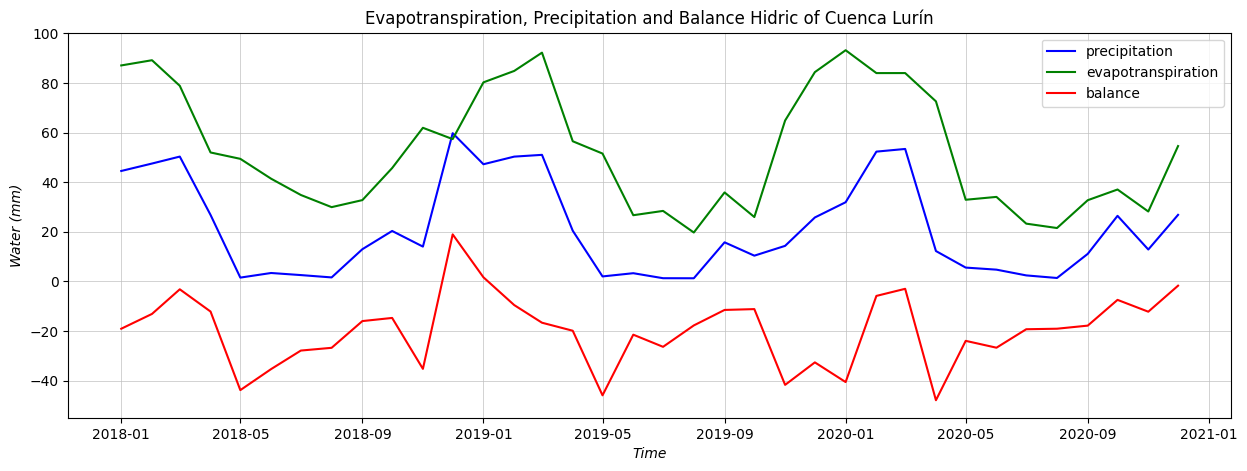

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(df.index, df["precipitation"], "b-", label = "precipitation")
plt.plot(df.index, df["evapotranspiration"], "g-", label = "evapotranspiration")
plt.plot(df.index, df["balance"], "r-", label = "balance")
plt.title(f"Evapotranspiration, Precipitation and Balance Hidric of {cuenca}")
plt.xlabel("Time", style = "italic")
plt.ylabel("Water (mm)", style = "italic")
plt.grid(True, color = "silver", lw = 0.5)
plt.legend()
plt.show()